
# EDA Multivariado — Consumo de Gas (Distribución, Estacionalidad y Correlación)

Cuaderno listo para ejecutar sobre **df_contugas.csv**, con:
- Revisión de **todas las variables numéricas** (histograma, boxplot, QQ-plot, normalidad).
- **Serie temporal**: gráfico, **ADF/KPSS**, **ACF/PACF** y **descomposición estacional** (periodo inferido).
- **Correlación** entre numéricas.
- **Análisis por Cliente** (opcional) para descubrir estacionalidad diaria/semanal y % de ceros.


In [1]:

# (Opcional) Bootstrap de dependencias en tu entorno local.
# Comenta esta celda si ya cuentas con estos paquetes.
try:
    import statsmodels, scipy  # noqa: F401
except Exception:
    %pip install --upgrade pip
    %pip install statsmodels scipy


In [2]:

# ============================
# Parámetros del análisis
# ============================
FILE_PATH = "df_contugas.csv"  # Cambia la ruta si es necesario
CSV_SEP = None      # None = autodetección ('engine="python"'); o pon ';' / ',' / '\t'
CLIENTE_TOP_N = 5   # Número de clientes a analizar individualmente
BY_CLIENT = True    # Activar análisis por cliente
SAMPLE_FOR_PLOTS = None  # Si el dataset es muy grande, fija un número (p.ej., 200000)

# ============================
# instalar librerías
# ============================
!pip install numpy pandas matplotlib scipy statsmodels
%pip install --upgrade pip
%pip install openpyxl statsmodels scipy

# ============================
# Importaciones
# ============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Optional

from scipy import stats
from statsmodels.api import qqplot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.stattools import jarque_bera

pd.set_option("display.max_columns", 140)
pd.set_option("display.width", 160)


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:

# =========================================
# Funciones auxiliares
# =========================================

def describe_normality(x: pd.Series, alpha: float = 0.05, sample_n: int = 10000) -> dict:
    x = x.dropna()
    n = len(x)
    out = {"n": int(n)}
    if n == 0:
        return out
    xs = x.sample(min(sample_n, n), random_state=42) if n > sample_n else x
    try:
        W, p = stats.shapiro(xs)
        out["shapiro_W"] = float(W); out["shapiro_p"] = float(p); out["shapiro_normal"] = bool(p > alpha)
    except Exception as e:
        out["shapiro_error"] = str(e)
    try:
        k2, p = stats.normaltest(x)
        out["dagostino_K2"] = float(k2); out["dagostino_p"] = float(p); out["dagostino_normal"] = bool(p > alpha)
    except Exception as e:
        out["dagostino_error"] = str(e)
    try:
        jb_stat, jb_p, _, _ = jarque_bera(x)
        out["jarque_bera"] = float(jb_stat); out["jarque_bera_p"] = float(jb_p); out["jarque_bera_normal"] = bool(jb_p > alpha)
    except Exception as e:
        out["jarque_bera_error"] = str(e)
    try:
        ad = stats.anderson(x, dist="norm")
        out["anderson_stat"] = float(ad.statistic)
        out["anderson_crit"] = [float(v) for v in ad.critical_values]
        out["anderson_sig"] = [float(v) for v in ad.significance_level]
    except Exception as e:
        out["anderson_error"] = str(e)
    try:
        out["skew"] = float(stats.skew(x)); out["kurtosis"] = float(stats.kurtosis(x, fisher=True))
    except Exception:
        pass
    return out

def infer_seasonal_period(series: pd.Series, max_lag: int = 400) -> Optional[int]:
    s = series.dropna().values
    if len(s) < 20:
        return None
    s = (s - np.mean(s)) / (np.std(s) if np.std(s) != 0 else 1)
    acf_vals = [1.0]
    L = min(max_lag, len(s) - 1)
    for lag in range(1, L+1):
        v = np.corrcoef(s[:-lag], s[lag:])[0,1] if len(s) - lag > 1 else np.nan
        acf_vals.append(v)
    acf_vals = np.array(acf_vals, dtype=float)
    thr = 0.25
    peaks = [i for i in range(1, len(acf_vals)) if not np.isnan(acf_vals[i]) and acf_vals[i] > thr]
    return peaks[0] if peaks else None

def adf_kpss_tests(series: pd.Series, alpha: float = 0.05) -> dict:
    res = {}
    x = series.dropna().values
    if len(x) < 20:
        return {"error": "Serie demasiado corta para ADF/KPSS"}
    try:
        adf_stat, adf_p, _, _, adf_crit, _ = adfuller(series.dropna(), autolag="AIC")
        res["adf_stat"] = float(adf_stat); res["adf_p"] = float(adf_p); res["adf_stationary_at_alpha"] = bool(adf_p < alpha)
        res["adf_crit"] = {k: float(v) for k, v in adf_crit.items()}
    except Exception as e:
        res["adf_error"] = str(e)
    try:
        kpss_stat, kpss_p, _, kpss_crit = kpss(series.dropna(), regression="c", nlags="auto")
        res["kpss_stat"] = float(kpss_stat); res["kpss_p"] = float(kpss_p); res["kpss_stationary_at_alpha"] = bool(kpss_p > alpha)
        res["kpss_crit"] = {k: float(v) for k, v in kpss_crit.items()}
    except Exception as e:
        res["kpss_error"] = str(e)
    return res


## 1) Carga y preprocesamiento

In [4]:

from pathlib import Path

path = Path(FILE_PATH)
assert path.exists(), f"No se encontró el archivo: {path}"

read_kwargs = {}
if CSV_SEP is None:
    read_kwargs.update(dict(sep=None, engine="python"))
else:
    read_kwargs.update(dict(sep=CSV_SEP))

df = pd.read_csv(path, **read_kwargs)
if SAMPLE_FOR_PLOTS is not None and len(df) > SAMPLE_FOR_PLOTS:
    df_sample = df.sample(SAMPLE_FOR_PLOTS, random_state=42).copy()
else:
    df_sample = df.copy()

print("Dimensiones:", df.shape)
display(df.head())

# Parseo de fecha (si existe)
date_col = None
for cand in ["Fecha", "fecha", "DATE", "Date", "timestamp", "time"]:
    if cand in df_sample.columns:
        date_col = cand; break

if date_col is not None:
    df_sample[date_col] = pd.to_datetime(df_sample[date_col], errors="coerce", dayfirst=True, infer_datetime_format=True)
    df_sample = df_sample.sort_values(date_col).set_index(date_col)

num_cols = df_sample.select_dtypes(include=[float, int]).columns.tolist()
cat_cols = [c for c in df_sample.columns if c not in num_cols]
print("Numéricas:", num_cols)
print("Categóricas:", cat_cols)

# Reporte de nulos
print("\nNulos por columna:")
print(df_sample.isna().sum())


Dimensiones: (847946, 6)


,﻿Fecha,Cliente,Segmento,Presion,Temperatura,Volumen
0,2019-01-14 00:00:00,CLIENTE1,Comercial,17.732563,28.209354,20.969751
1,2019-01-14 01:00:00,CLIENTE1,Comercial,17.747776,28.518614,17.845739
2,2019-01-14 02:00:00,CLIENTE1,Comercial,17.758916,28.230191,20.975914
3,2019-01-14 03:00:00,CLIENTE1,Comercial,17.727940,27.811509,20.592299
4,2019-01-14 04:00:00,CLIENTE1,Comercial,17.746484,27.795293,21.690626


Numéricas: ['Presion', 'Temperatura', 'Volumen']
Categóricas: ['\ufeffFecha', 'Cliente', 'Segmento']

Nulos por columna:
﻿Fecha         0
Cliente        0
Segmento       0
Presion        0
Temperatura    0
Volumen        0
dtype: int64


## 2) Resumen de normalidad (todas las numéricas)

In [6]:

rows = []
for c in num_cols:
    info = describe_normality(df_sample[c].astype(float))
    info["variable"] = c
    rows.append(info)
normality_df = pd.DataFrame(rows).set_index("variable")
display(normality_df)
# Guardar a CSV
out_dir = Path("data/outputs"); out_dir.mkdir(parents=True, exist_ok=True)
normality_df.to_csv(out_dir / "normalidad_variables.csv")
print("Guardado:", out_dir / "normalidad_variables.csv")


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10000.
  res = hypotest_fun_out(*samples, **kwds)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10000.
  res = hypotest_fun_out(*samples, **kwds)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10000.
  res = hypotest_fun_out(*samples, **kwds)


,n,shapiro_W,shapiro_p,shapiro_normal,dagostino_K2,dagostino_p,dagostino_normal,jarque_bera,jarque_bera_p,jarque_bera_normal,anderson_stat,anderson_crit,anderson_sig,skew,kurtosis
variable,,,,,,,,,,,,,,,
Presion,847946,0.431349,8.948042e-101,False,426501.060327,0.0,False,1.846373e+06,0.0,False,224214.061650,"[0.576, 0.656, 0.787, 0.918, 1.092]","[15.0, 10.0, 5.0, 2.5, 1.0]",-2.621133,4.977733
Temperatura,847946,0.995985,5.338716e-16,False,3118.382555,0.0,False,3.045523e+03,0.0,False,968.855615,"[0.576, 0.656, 0.787, 0.918, 1.092]","[15.0, 10.0, 5.0, 2.5, 1.0]",-0.130866,-0.133024
Volumen,847946,0.776638,5.821267e-79,False,128437.798480,0.0,False,1.983525e+05,0.0,False,77287.150056,"[0.576, 0.656, 0.787, 0.918, 1.092]","[15.0, 10.0, 5.0, 2.5, 1.0]",1.184289,0.062776


Guardado: data/outputs/normalidad_variables.csv


## 3) Gráficos por variable numérica

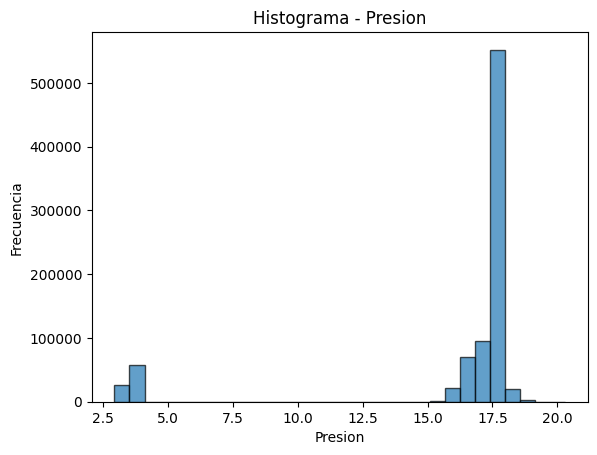

/var/folders/yg/frmjyrxj687gg0zt2sfq8zkm0000gn/T/ipykernel_10087/3742890902.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(s.values, vert=True, labels=[c])


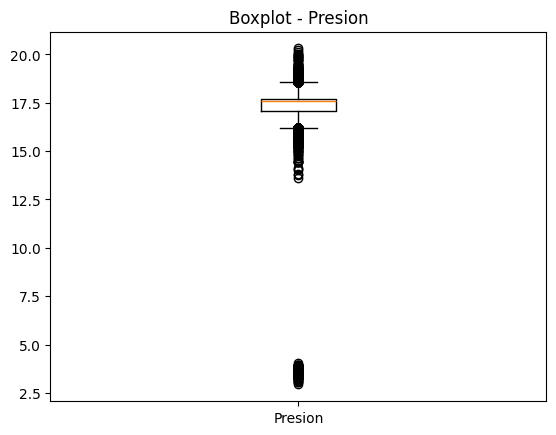

<Figure size 640x480 with 0 Axes>

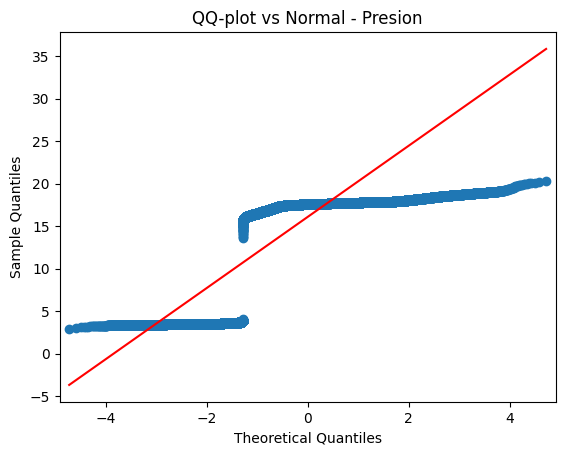

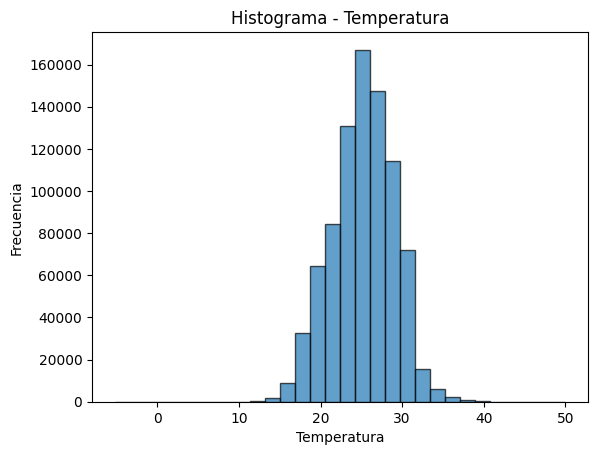

/var/folders/yg/frmjyrxj687gg0zt2sfq8zkm0000gn/T/ipykernel_10087/3742890902.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(s.values, vert=True, labels=[c])


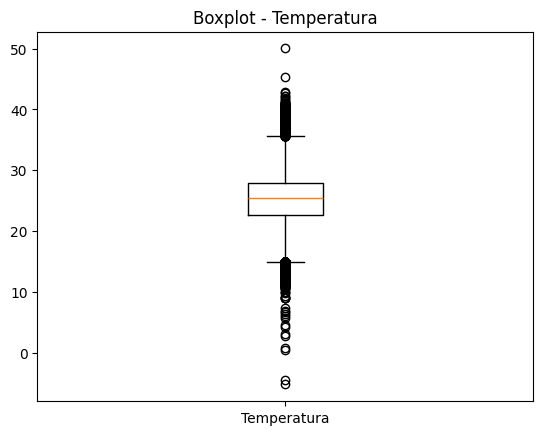

<Figure size 640x480 with 0 Axes>

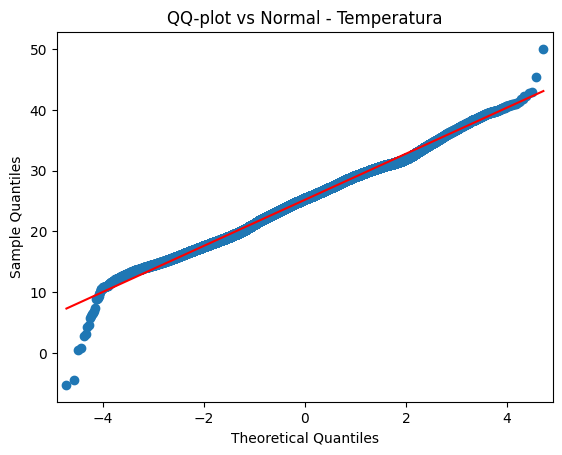

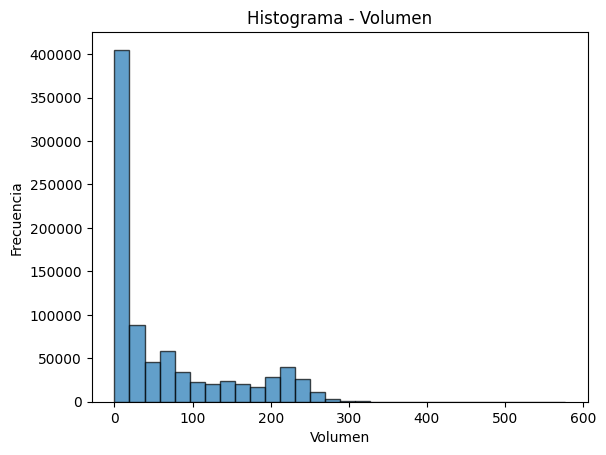

/var/folders/yg/frmjyrxj687gg0zt2sfq8zkm0000gn/T/ipykernel_10087/3742890902.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(s.values, vert=True, labels=[c])


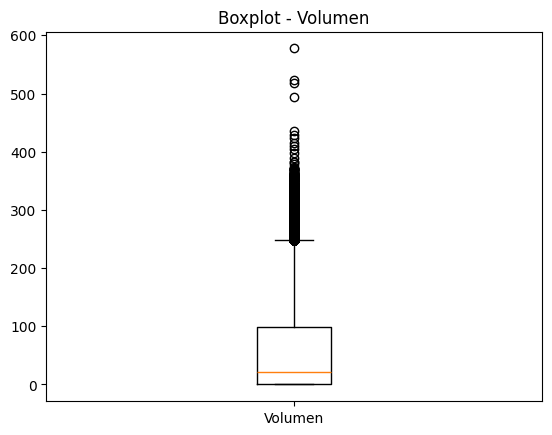

<Figure size 640x480 with 0 Axes>

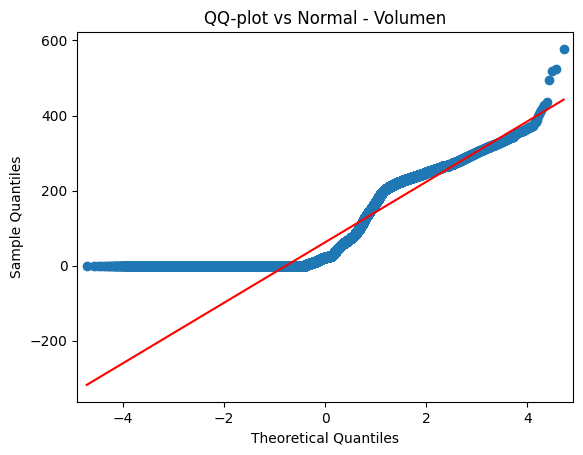

In [7]:

for c in num_cols:
    s = df_sample[c].dropna().astype(float)
    if s.empty:
        continue
    # Histograma
    plt.figure()
    s.plot(kind="hist", bins=30, edgecolor="black", alpha=0.7)
    plt.title(f"Histograma - {c}")
    plt.xlabel(c); plt.ylabel("Frecuencia")
    plt.show()
    # Boxplot
    plt.figure()
    plt.boxplot(s.values, vert=True, labels=[c])
    plt.title(f"Boxplot - {c}")
    plt.show()
    # QQ-plot
    plt.figure()
    qqplot(s, line='s')
    plt.title(f"QQ-plot vs Normal - {c}")
    plt.show()


## 4) Series temporales y estacionalidad por variable numérica

In [8]:

if isinstance(df_sample.index, pd.DatetimeIndex):
    for c in num_cols:
        s = df_sample[c].dropna().astype(float)
        if len(s) < 50:
            continue
        # Serie temporal
        plt.figure()
        s.plot()
        plt.title(f"Serie temporal - {c}")
        plt.xlabel("Fecha"); plt.ylabel(c)
        plt.show()

        # ADF / KPSS
        print(f"Pruebas de estacionariedad - {c}")
        tests = adf_kpss_tests(s)
        for k, v in tests.items():
            print(f"  - {k}: {v}")

        # ACF / PACF
        plt.figure()
        plot_acf(s, lags=40)
        plt.title(f"ACF - {c}")
        plt.show()

        plt.figure()
        plot_pacf(s, lags=40, method="ywm")
        plt.title(f"PACF - {c}")
        plt.show()

        # Descomposición
        period = infer_seasonal_period(s)
        print(f"Periodo estacional inferido ({c}):", period)
        if period is not None and period >= 2:
            try:
                res = seasonal_decompose(s.dropna(), period=period, model="additive", extrapolate_trend="freq")
                plt.figure(); res.observed.plot(); plt.title(f"Descomposición Observado - {c}"); plt.show()
                plt.figure(); res.trend.plot();    plt.title(f"Descomposición Tendencia - {c}"); plt.show()
                plt.figure(); res.seasonal.plot();  plt.title(f"Descomposición Estacionalidad - {c}"); plt.show()
                plt.figure(); res.resid.plot();     plt.title(f"Descomposición Residual - {c}"); plt.show()
            except Exception as e:
                print(f"Error en descomposición para {c}:", e)
else:
    print("El índice no es datetime; no se generan gráficos temporales.")


El índice no es datetime; no se generan gráficos temporales.


## 5) Variables categóricas — vistas rápidas

In [9]:

for c in cat_cols:
    vc = df_sample[c].value_counts(dropna=False).head(20)
    print(f"Top categorías en {c}:")
    display(vc.to_frame(name="conteo"))


Top categorías en ﻿Fecha:


,conteo
﻿Fecha,
2019-01-14 00:00:00,20
2022-02-08 01:00:00,20
2022-02-08 03:00:00,20
2022-02-08 04:00:00,20
2022-02-08 05:00:00,20
2022-02-08 06:00:00,20
2022-02-08 07:00:00,20
2022-02-08 08:00:00,20
2022-02-08 09:00:00,20


Top categorías en Cliente:


,conteo
Cliente,
CLIENTE5,43415
CLIENTE14,43415
CLIENTE1,43412
CLIENTE17,43412
CLIENTE8,43146
CLIENTE16,43146
CLIENTE6,42808
CLIENTE20,42808
CLIENTE9,42428


Top categorías en Segmento:


,conteo
Segmento,
Comercial,591544
Industrial,256402


## 6) Correlación numérica

Matriz de correlación:


,Presion,Temperatura,Volumen
Presion,1.000000,-0.117924,-0.303627
Temperatura,-0.117924,1.000000,0.334409
Volumen,-0.303627,0.334409,1.000000


Guardado: data/outputs/correlacion_numericas.csv


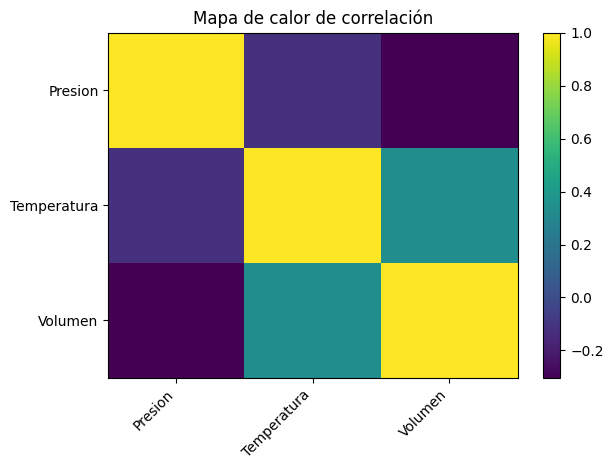

In [11]:

num_df = df_sample[num_cols].dropna(how="all")
if num_df.shape[1] >= 2:
    corr = num_df.corr(numeric_only=True)
    print("Matriz de correlación:")
    display(corr)
    corr.to_csv("data/outputs/correlacion_numericas.csv")
    print("Guardado:", "data/outputs/correlacion_numericas.csv")

    plt.figure()
    plt.imshow(corr.values, aspect="auto")
    plt.xticks(range(corr.shape[1]), corr.columns, rotation=45, ha="right")
    plt.yticks(range(corr.shape[0]), corr.index)
    plt.title("Mapa de calor de correlación")
    plt.colorbar()
    plt.tight_layout()
    plt.show()
else:
    print("No hay suficientes columnas numéricas para correlación.")


## 7) Análisis por Cliente (opcional)

In [12]:

if BY_CLIENT and "Cliente" in df.columns:
    base = df.copy()
    if date_col is not None and date_col in base.columns:
        base[date_col] = pd.to_datetime(base[date_col], errors="coerce", dayfirst=True, infer_datetime_format=True)
        base = base.dropna(subset=[date_col])
    if date_col is not None:
        base = base.sort_values(date_col)
    # Top N por volumen de datos
    top_clients = base["Cliente"].value_counts().head(CLIENTE_TOP_N).index.tolist()
    print("Clientes analizados:", top_clients)

    for cli in top_clients:
        sub = base[base["Cliente"] == cli].copy()
        if date_col is not None:
            sub = sub.set_index(date_col)
        # Asegurar tipo numérico
        for c in ["Volumen", "Temperatura", "Presion"]:
            if c in sub.columns:
                sub[c] = pd.to_numeric(sub[c], errors="coerce")

        print(f"\n=== Cliente: {cli} | Observaciones: {len(sub)} ===")
        if len(sub) < 50 or not isinstance(sub.index, pd.DatetimeIndex):
            print("Insuficiente para análisis temporal.")
            continue

        s = sub["Volumen"].dropna().astype(float)
        # % de ceros
        zero_ratio = (s == 0).mean()
        print(f"Proporción de ceros en Volumen: {zero_ratio:.3%}")

        # Serie y ACF/PACF
        plt.figure(); s.plot(); plt.title(f"Serie Volumen - {cli}"); plt.xlabel("Fecha"); plt.ylabel("Volumen"); plt.show()
        plt.figure(); plot_acf(s, lags=40); plt.title(f"ACF Volumen - {cli}"); plt.show()
        plt.figure(); plot_pacf(s, lags=40, method="ywm"); plt.title(f"PACF Volumen - {cli}"); plt.show()

        # Estacionalidad por hora del día / día de semana
        sub["hora"] = sub.index.hour
        sub["dow"] = sub.index.dayofweek  # 0=Lunes
        grp_hod = sub.groupby("hora")["Volumen"].median()
        grp_dow = sub.groupby("dow")["Volumen"].median()

        plt.figure(); grp_hod.plot(); plt.title(f"Mediana Volumen por Hora del día - {cli}"); plt.xlabel("Hora"); plt.ylabel("Mediana Volumen"); plt.show()
        plt.figure(); grp_dow.plot(); plt.title(f"Mediana Volumen por Día de semana - {cli}"); plt.xlabel("Día (0=L)"); plt.ylabel("Mediana Volumen"); plt.show()

        # Estacionariedad
        tests = adf_kpss_tests(s)
        print("ADF/KPSS:", tests)

        # Periodo estacional
        per = infer_seasonal_period(s)
        print("Periodo estacional inferido:", per)
else:
    print("BY_CLIENT=False o no existe la columna 'Cliente'.")


Clientes analizados: ['CLIENTE5', 'CLIENTE14', 'CLIENTE1', 'CLIENTE17', 'CLIENTE8']

=== Cliente: CLIENTE5 | Observaciones: 43415 ===
Insuficiente para análisis temporal.

=== Cliente: CLIENTE14 | Observaciones: 43415 ===
Insuficiente para análisis temporal.

=== Cliente: CLIENTE1 | Observaciones: 43412 ===
Insuficiente para análisis temporal.

=== Cliente: CLIENTE17 | Observaciones: 43412 ===
Insuficiente para análisis temporal.

=== Cliente: CLIENTE8 | Observaciones: 43146 ===
Insuficiente para análisis temporal.
